In [1]:
## Get FGPU iPython Package

In [2]:
!sudo -H pip install --upgrade 'git+https://github.com/malkadi/FGPU_IPython'

  Cloning https://github.com/malkadi/FGPU_Python to /tmp/pip-rg0eeiae-build
^C
Operation cancelled by user


## Kernel Code

In [13]:
%%writefile compass_edge_detection.cl
#include "FGPUlib.c"

__kernel void compass_edge_detection(__global unsigned *in, __global unsigned *amplitude)
{
  unsigned x = get_global_id(1);
  unsigned y = get_global_id(0);
  unsigned rowLen = get_global_size(0);


  // return on boarder pixels
  bool border =  x < 1 | y < 1 | (x>rowLen-2) | (y>rowLen-2);
  if(border) 
    return;

  unsigned p[3][3];
  unsigned p00 = in[(x-1)*rowLen+y-1];
  unsigned p01 = in[(x-1)*rowLen+y];
  unsigned p02 = in[(x-1)*rowLen+y+1];
  unsigned p10 = in[x*rowLen+y-1];
  unsigned p11 = in[x*rowLen+y];
  unsigned p12 = in[x*rowLen+y+1];
  unsigned p20 = in[(x+1)*rowLen+y-1];
  unsigned p21 = in[(x+1)*rowLen+y];
  unsigned p22 = in[(x+1)*rowLen+y+1];
  int G[8] = {0};
  G[0] =  -1*p00 +0*p01 +1*p02 +
          -2*p10 +0*p11 +2*p12 +
          -1*p20 +0*p21 +1*p22;
  G[1] =  -2*p00 -1*p01 +0*p02 +
          -1*p10 +0*p11 +1*p12 +
          -0*p20 +1*p21 +2*p22;
  G[2] =  -1*p00 -2*p01 -1*p02 +
          -0*p10 +0*p11 +0*p12 +
          +1*p20 +2*p21 +1*p22;
  G[3] =  -0*p00 -1*p01 -2*p02 +
          +1*p10 +0*p11 -1*p12 +
          +2*p20 +1*p21 +0*p22;
  G[4] = -G[0];
  G[5] = -G[1];
  G[6] = -G[2];
  G[7] = -G[3];
  int max_val = G[0], i;
  for(i = 1; i < 8; i++)
    max_val = G[i] < max_val ? max_val:G[i];

  amplitude[x*rowLen+y] = max_val;
}


Overwriting compass_edge_detection.cl


## Create Objects

In [14]:
from FGPU import FGPU
from FGPU import xlnk

fgpu= FGPU()
mem=xlnk.xlnk()
mem.cma_stats()

{'Buffer Count': 0, 'CMA Memory Available': 116215808, 'CMA Memory Usage': 0}

## Program Hardware

In [5]:
fgpu.set_bitFile("V2_8CUs_noAtomic_SubInteger_235MHz.bit")
fgpu.download_bitstream()

## Compile Kernel

In [15]:
fgpu.set_kernel_file("compass_edge_detection.cl")
fgpu.compile_kernel()

Compiling /home/muhammed/FGPU_iPython/notebooks/compass_edge_detection.cl
Compiling succeeded!



/usr/local/lib/python3.4/dist-packages/FGPU/code.bin:	file format ELF32-fgpu

Disassembly of section .text:
compass_edge_detection:
       0:	22 00 00 a0 	lid	r2, 1
       4:	24 00 00 a1 	wgoff	r4, 1
       8:	03 00 00 a0 	lid	r3, 0
       c:	05 00 00 a1 	wgoff	r5, 0
      10:	a3 0c 00 10 	add	r3, r5, r3
      14:	84 08 00 10 	add	r4, r4, r2
      18:	81 00 00 34 	xor	r1, r4, r0
      1c:	21 04 00 b7 	sltiu	r1, r1, 1
      20:	62 00 00 34 	xor	r2, r3, r0
      24:	42 04 00 b7 	sltiu	r2, r2, 1
      28:	42 04 00 32 	or	r2, r2, r1
      2c:	05 00 00 a2 	size	r5, 0
      30:	a1 f8 ff 11 	addi	r1, r5, -2
      34:	26 10 00 b6 	sltu	r6, r1, r4
      38:	42 18 00 32 	or	r2, r2, r6
      3c:	21 0c 00 b6 	sltu	r1, r1, r3
      40:	41 04 00 32 	or	r1, r2, r1
      44:	01 30 01 63 	bne	r1, r0, 76
      48:	21 00 00 a8 	lp	r1, 1
      4c:	06 00 00 a8 	lp	r6, 0
      50:	82 fc ff 11 	addi	r2, r4, -1
 

## Read Input Image & Allocate Memory

In [16]:
import scipy.misc
import sys
from cffi import FFI
import numpy as np
ffi = FFI()
img=scipy.misc.lena()
nRows = img.shape[0];
nCols = img.shape[1];
length = nRows*nCols # length of input and output array
img_ptr = mem.cma_alloc(length, data_type = "unsigned")
amplitude = mem.cma_alloc(length, data_type = "unsigned")
if type(img) == np.ndarray:
    ffi.memmove(img_ptr, img, img.size*img.dtype.itemsize)
else:
    AssertionError()
mem.cma_stats()

{'Buffer Count': 2,
 'CMA Memory Available': 114823168,
 'CMA Memory Usage': 2097152}

## Configure Kernel

In [17]:
# bind allocated memory to kenel parameters
fgpu.set_paramerter(0, img_ptr, mem)
fgpu.set_paramerter(1, amplitude, mem)
# setup index space
fgpu.set_num_dimensions(2)
fgpu.set_size(size=nCols, dim=0)
fgpu.set_size(size=nRows, dim=1)
fgpu.set_work_group_size(wg_size=8, dim=0)
fgpu.set_work_group_size(wg_size=8, dim=1)
fgpu.set_offset(value=0, dim=0)
fgpu.set_offset(value=0, dim=1)
fgpu.prepare_kernel_descriptor()

## Compute withpout FGPU

Execution time = 265907 us


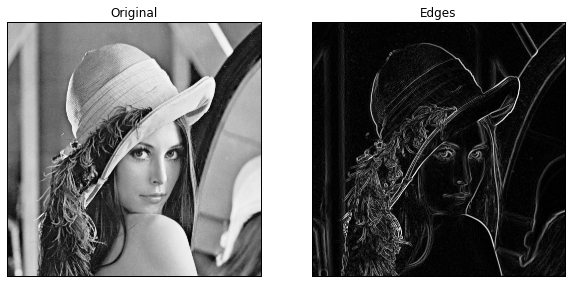

In [18]:
import numpy as np
import scipy.misc 
import scipy.ndimage
import time
from matplotlib import pyplot as plt

def detect_edges(image,masks):
    edges = abs(scipy.ndimage.convolve(image,masks[0]))
    for mask in masks[1:4]:
        edges=np.maximum(abs(scipy.ndimage.convolve(image,mask)), edges)
    return edges

Sobel=[
        [
        [-1,+0,+1],
        [-2,+0,+2],
        [-1,+0,+1]
        ],
        [
        [-2,-1,+0],
        [-1,+0,+1],
        [+0,+1,+2]
        ],
        [
        [-1,-2,-1],
        [+0,+0,+0],
        [+1,+2,+1]
        ],
        [
        [-0,-1,-2],
        [+1,+0,-1],
        [+2,+1,+0]
        ] 
]
start = time.time()
edges=detect_edges(img, Sobel)
end = time.time()
print ("Execution time =", int((end-start)*1000000), "us")

plt.figure(1, figsize=(10, 10))
plt.subplot(121),plt.imshow(img, cmap='Greys_r'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges, cmap='Greys_r'),plt.title('Edges')
plt.xticks([]), plt.yticks([])
plt.show()

## Execute On FGPU

In [31]:
fgpu.download_kernel()
execTime = fgpu.execute_kernel()
print ("Execution time =", int(execTime*1000000), "us")


Execution time = 4900 us


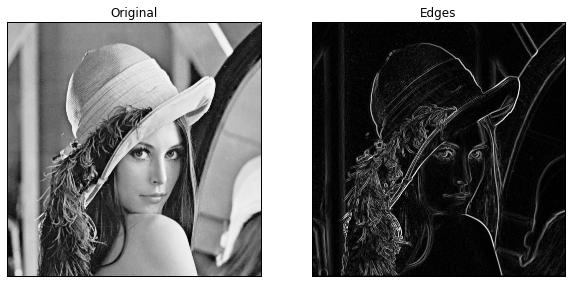

In [32]:
from matplotlib import pyplot as plt
import numpy as np
buffer_size = img.size*img.dtype.itemsize
c_buffer = ffi.buffer(amplitude,buffer_size)
amplitude_ndarray = np.frombuffer(c_buffer, dtype=img.dtype)
am = amplitude_ndarray.reshape(img.shape)

#rc_image = mem.cma_cast(img_ptr, "int")
#amplitude_fgpu = mem.cma_cast(amplitude, "int")
plt.figure(1, figsize=(10, 10))
plt.subplot(121),plt.imshow(img, cmap='Greys_r'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(am, cmap='Greys_r'),plt.title('Edges')
plt.xticks([]), plt.yticks([])
plt.show()

## Check Results

In [33]:
amplitude_fgpu = mem.cma_cast(amplitude, "int")
nErrors = 0
for i in range(1, nRows-1):
    for j in range(1, nCols-1):
        if edges[i][j] != amplitude_fgpu[i*nCols+j]:
            nErrors += 1;
            
if nErrors == 0:
    print ("no Errors found!")
else:
    print (nErrors, "Errors found!")

no Errors found!
